In [12]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

### Problem Summary
This project aims to determine which features are predictive of stroke. Stroke is one of the leading causes of death and long-term disability worldwide. Prompt identification and intervention can significantly reduce the severe outcomes, including paralysis, speech difficulties and even death. According to the WHO, 15 million people worldwide have a stroke each year, with 5 million dying and 5 million becoming permanently disabled.

Predicting stroke risk can help identify individuals who would benefit from preventative measures, such as lifestyle changes and medications. High risk individuals can be monitored more closely.


### Data
The stroke dataset from Kaggle includes a patient id, 10 features and an outcome variable for stroke. Details about each variable in the dataset are presented below:
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [35]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [37]:
print(data.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


## Data Exploration
Impute missing bmi data with the mean of the non-missing data and convert categorical features to dummy variables. 


In [39]:
data['bmi'].fillna((data['bmi'].mean()), inplace=True)

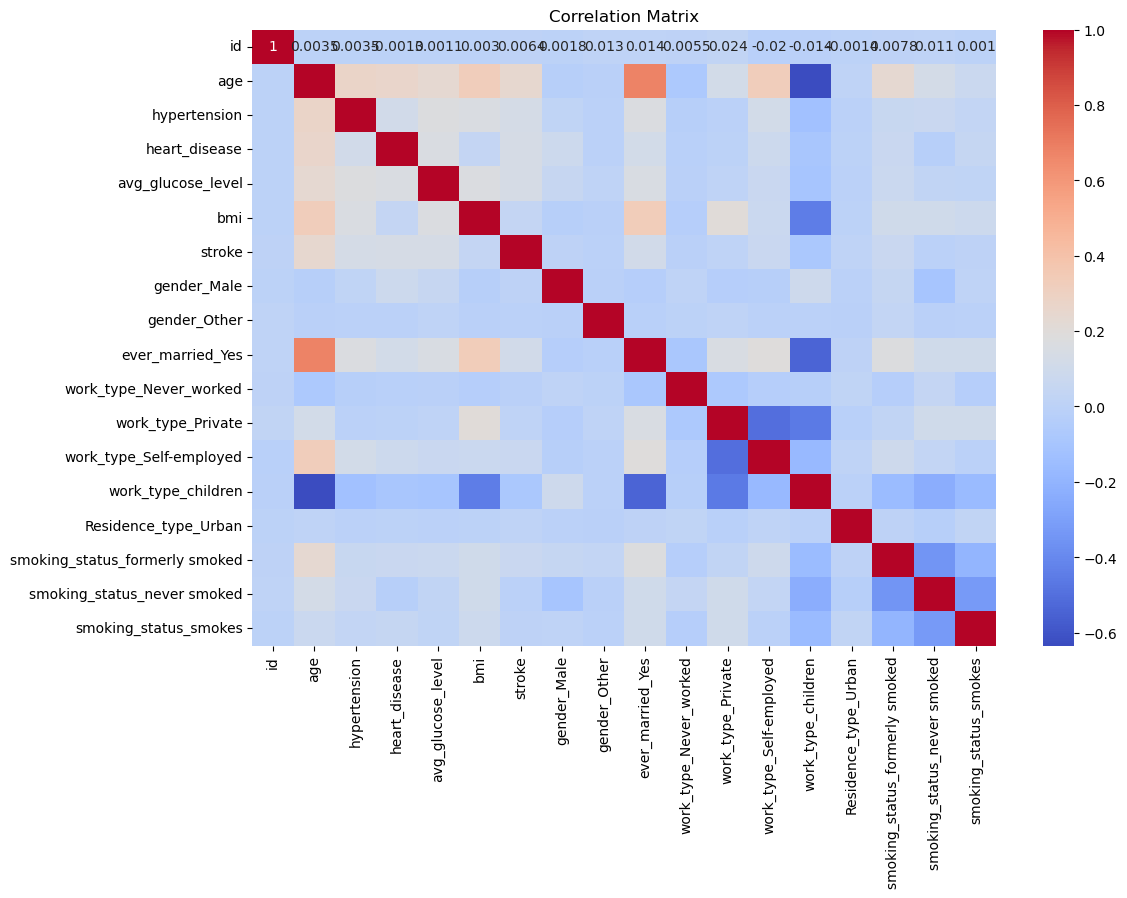

In [41]:
#Create dummy variables for the categorical variables
data=pd.get_dummies(data, drop_first=True)
# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

From the correlation heat map, age, hypertension, heart disease, average glucose level and marital status seem to be most correlated with the outcome of stroke. 

In [43]:
X=data.drop(columns=['id', 'stroke'])
y=data['stroke']

#now split X and y into test and train datasets so that 30% of the data is in the train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

We need to oversample the stroke cases from the training dataset because this category is underrepresented in our data. Once we have done that we can normalise the data before modelling it.

In [45]:
#we need to oversample from the train dataset
#Initialize RandomOverSampler
oversampler=RandomOverSampler(sampling_strategy='minority', random_state=3)

#Oversample the training data
X_train_oversampled, y_train_oversampled=oversampler.fit_resample(X_train,y_train)

In [47]:
# Check the shapes of the datasets
print(f'Shape of X_train_oversampled: {X_train_oversampled.shape}')
print(f'Shape of y_train: {y_train_oversampled.shape}')
print(f'Shape of X_test_normalised: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train_oversampled: (6790, 16)
Shape of y_train: (6790,)
Shape of X_test_normalised: (1533, 16)
Shape of y_test: (1533,)


In [51]:
#Normalise the data
scaler=MinMaxScaler(feature_range=(0,1))

scaler.fit(X_train_oversampled)
X_train_normalised=scaler.transform(X_train_oversampled)
X_test_normalised=scaler.transform(X_test)

#Convert the normalised data into dataframes, ready for analysis
X_train_normalised=pd.DataFrame(X_train_normalised, columns=X_train.columns)
X_test_normalised=pd.DataFrame(X_test_normalised, columns=X_test.columns)

print(f'Shape of X_train_normalised: {X_train_normalised.shape}')
print(f'Shape of y_train: {y_train_oversampled.shape}')
print(f'Shape of X_test_normalised: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train_normalised: (6790, 16)
Shape of y_train: (6790,)
Shape of X_test_normalised: (1533, 16)
Shape of y_test: (1533,)


## Fit Models to the Data
Models considered for the stroke dataset include logistic regression, a decision tree, random forest and support vector machine.


In [53]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', C=1.0),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', max_depth=5),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=5),
    "Support Vector Machine": SVC(class_weight='balanced', probability=True)
}

# Training and evaluating each model
for name, model in models.items():
    model.fit(X_train_normalised, y_train_oversampled)

## Compare Models
Models will be compared using confusion matrix, accuracy score, classification report

In [55]:
for name, model in models.items():
    y_pred = model.predict(X_test_normalised)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1466
           1       0.12      0.82      0.21        67

    accuracy                           0.72      1533
   macro avg       0.55      0.77      0.52      1533
weighted avg       0.95      0.72      0.81      1533

[[1056  410]
 [  12   55]]
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1466
           1       0.11      0.75      0.19        67

    accuracy                           0.72      1533
   macro avg       0.55      0.73      0.51      1533
weighted avg       0.95      0.72      0.80      1533

[[1052  414]
 [  17   50]]
Model: Random Forest
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      1466
           1       0.12      0.90      0.21        67

    accuracy                           0.70      1533
   ma

## Model Performance
The models seem to have similar performance but the precision from the logistic regression model is slightly higher than the others. Since we would be most interested in predicting a true stroke case logistic regression model would be selected for this problem.

## Logistic Regression Coefficients
Examining the coefficients from the logistic model enables us to determine which features are most predictive of stroke in this model.

In [62]:
model=LogisticRegression()
model.fit(X_train_normalised, y_train_oversampled)
coefficients=model.coef_[0]
intercept=model.intercept_[0]

coef_df=pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
print(f"Intercept: {intercept}")
print(coef_df)

Intercept: -5.001518942248633
                           Feature  Coefficient
0                              age     6.654743
1                     hypertension     0.441006
2                    heart_disease     0.406874
3                avg_glucose_level     0.504142
4                              bmi     1.160697
5                      gender_Male    -0.229061
6                     gender_Other    -0.079478
7                 ever_married_Yes    -0.077782
8           work_type_Never_worked    -0.324061
9                work_type_Private    -0.065210
10         work_type_Self-employed    -0.593771
11              work_type_children     1.783647
12            Residence_type_Urban     0.188803
13  smoking_status_formerly smoked     0.298781
14     smoking_status_never smoked    -0.248652
15           smoking_status_smokes     0.233978


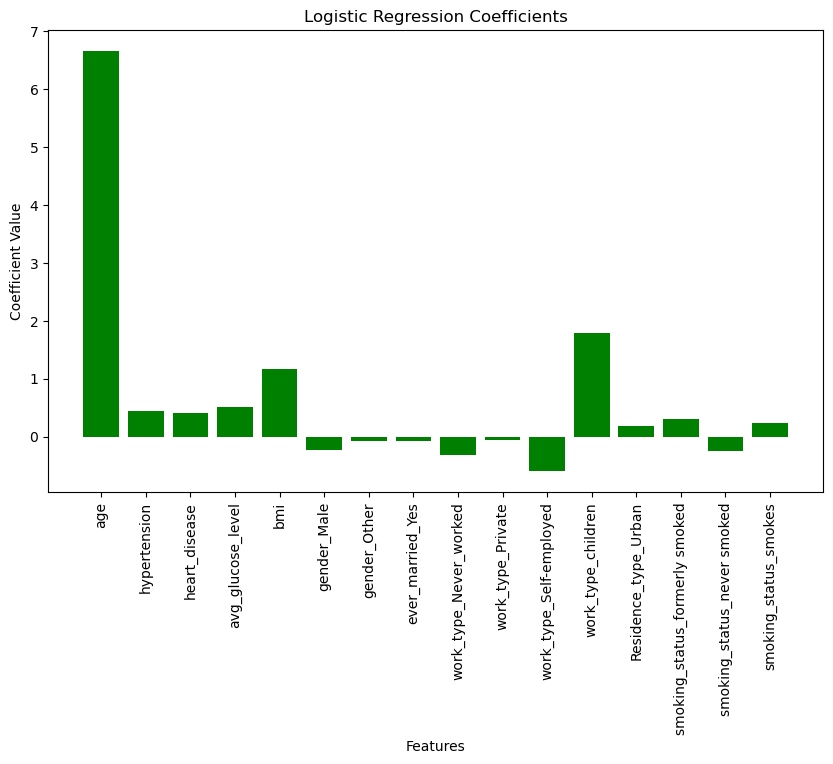

In [64]:
plt.figure(figsize=(10,6))
plt.bar(coef_df['Feature'], coef_df['Coefficient'], color='green')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.xticks(rotation=90, ha='center')
plt.show()

Further investigation into the fact that children seem to be at higher risk of stroke is required, particularly because risk of stroke is meant to increase with age.

## Remove Children from the Dataset
Of the 5110 participants included in this dataset, 687 were children (work_type=children) and of those individuals, 2 had a stroke. Including participants under the age of 18 seems to be uninformative for this analysis. I would advise researchers to aim to identify more children who had experienced a stroke in order to improve the ability of the model to predict stroke in children. As a result of this, children under 18 years of age were removed from the analysis.


In [67]:
data=data[data['age']>=18]

X=data.drop(columns=['id', 'stroke'])
y=data['stroke']

#now split X and y into test and train datasets so that 30% of the data is in the train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
#now split X and y into test and train datasets so that 30% of the data is in the train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [69]:
#we need to oversample from the train dataset
#Initialize RandomOverSampler
oversampler=RandomOverSampler(sampling_strategy='minority', random_state=3)

#Oversample the training data
X_train_oversampled, y_train_oversampled=oversampler.fit_resample(X_train,y_train)

In [71]:
#Normalise the data
scaler=MinMaxScaler(feature_range=(0,1))

scaler.fit(X_train_oversampled)
X_train_normalised=scaler.transform(X_train_oversampled)
X_test_normalised=scaler.transform(X_test)

#Convert the normalised data into dataframes, ready for analysis
X_train_normalised=pd.DataFrame(X_train_normalised, columns=X_train.columns)
X_test_normalised=pd.DataFrame(X_test_normalised, columns=X_test.columns)

print(f'Shape of X_train_normalised: {X_train_normalised.shape}')
print(f'Shape of y_train: {y_train_oversampled.shape}')
print(f'Shape of X_test_normalised: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train_normalised: (5608, 16)
Shape of y_train: (5608,)
Shape of X_test_normalised: (1277, 16)
Shape of y_test: (1277,)


In [73]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', C=1.0),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', max_depth=5),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=5),
    "Support Vector Machine": SVC(class_weight='balanced', probability=True)
}

# Training and evaluating each model
for name, model in models.items():
    model.fit(X_train_normalised, y_train_oversampled)

In [74]:
for name, model in models.items():
    y_pred = model.predict(X_test_normalised)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1203
           1       0.15      0.82      0.26        74

    accuracy                           0.72      1277
   macro avg       0.57      0.77      0.54      1277
weighted avg       0.94      0.72      0.80      1277

[[860 343]
 [ 13  61]]
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1203
           1       0.17      0.74      0.27        74

    accuracy                           0.77      1277
   macro avg       0.57      0.76      0.57      1277
weighted avg       0.93      0.77      0.83      1277

[[927 276]
 [ 19  55]]
Model: Random Forest
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1203
           1       0.15      0.78      0.26        74

    accuracy                           0.74      1277
   macro avg 

## Model Performance
The models seem to have similar performance but the precision from the logistic regression model is slightly higher than the others. Since we would be most interested in predicting a true stroke case logistic regression model would be selected for this problem.

## Logistic Regression Coefficients
Examining the coefficients from the logistic model enables us to determine which features are most predictive of stroke in this model.

In [82]:
model=LogisticRegression()
model.fit(X_train_normalised, y_train_oversampled)
coefficients=model.coef_[0]
intercept=model.intercept_[0]

coef_df=pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
print(f"Intercept: {intercept}")
print(coef_df)

Intercept: -3.4982270702567213
                           Feature  Coefficient
0                              age     4.351834
1                     hypertension     0.515885
2                    heart_disease     0.421442
3                avg_glucose_level     0.939823
4                              bmi     0.707237
5                      gender_Male    -0.181497
6                     gender_Other    -0.091278
7                 ever_married_Yes     0.081421
8           work_type_Never_worked    -0.129251
9                work_type_Private     0.364240
10         work_type_Self-employed     0.004362
11              work_type_children     0.000000
12            Residence_type_Urban     0.103305
13  smoking_status_formerly smoked    -0.094632
14     smoking_status_never smoked    -0.476314
15           smoking_status_smokes     0.079083


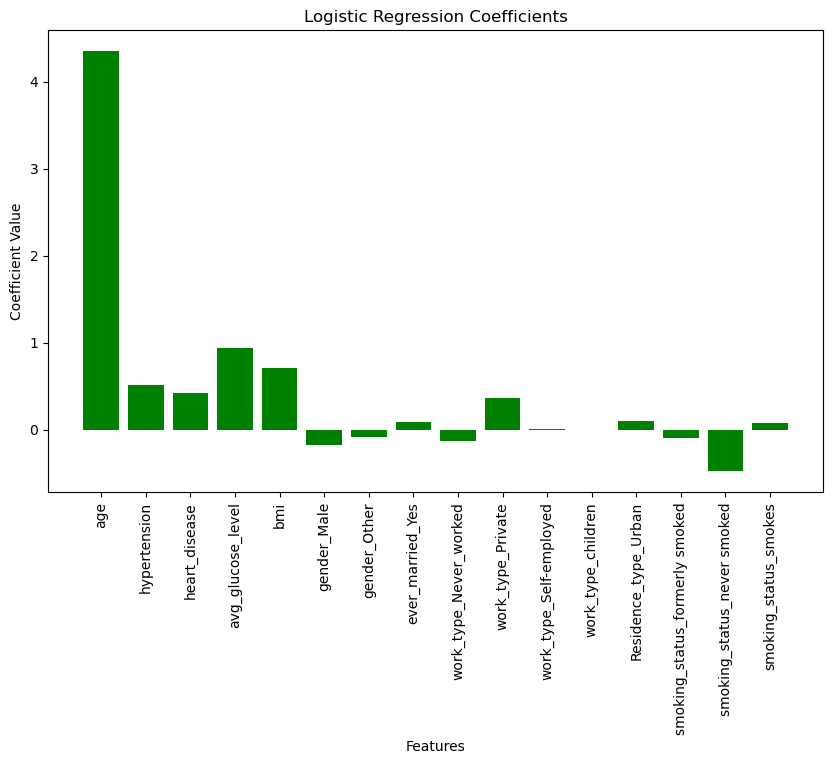

In [33]:
plt.figure(figsize=(10,6))
plt.bar(coef_df['Feature'], coef_df['Coefficient'], color='green')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.xticks(rotation=90, ha='center')
plt.show()